In [362]:
import random, pickle, json, os
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import re, unidecode

In [363]:
# nltk.download('all')

In [364]:
def getJsonFiles():
    data = []
    for file_name in os.listdir('TrainData'):
        file_path = os.path.join('TrainData', file_name)

        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                jsonFile = json.load(f)
                data.extend(jsonFile) 
            except Exception as error:
                continue
    return data


intents = getJsonFiles()
print(intents[2])

{'tag': 'sighir', 'patterns': ['O que é a Sighir?', 'Me fale sobre a Sighir', 'Você conhece a Sighir?', 'Qual é a área de atuação da Sighir?', 'A Sighir trabalha com o que?', 'Quais são os produtos da Sighir?', 'Onde a Sighir opera?', 'Qual é a missão da Sighir?', 'Como funciona a Sighir?', 'O que torna a Sighir especial?'], 'responses': ['A Sighir é uma startup focada em soluções de tecnologia, como o etilômetro veicular.', 'A Sighir trabalha com inovação tecnológica.', 'A Sighir é uma empresa brasileira reconhecida por seus projetos no setor de tecnologia!']}


# FORMATANDO DADOS

In [365]:
lemmatizer = WordNetLemmatizer()
words, classes, documents = [], [], []

In [366]:
ignoreWords = ['?', '!', '*', '/', '+', '-', '.', ',']
ignoreWords[:5]

['?', '!', '*', '/', '+']

In [367]:
def cleanText(sentence):
    sentence = sentence.lower().strip()
    #sentence = unidecode.unidecode(sentence) 
    #sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence) 
    #sentence = re.sub(r'\s+', ' ', sentence).strip() 
    return sentence


cleanText('Olá, Tudo BEM contigo?')

'olá, tudo bem contigo?'

In [368]:
for intent in intents:
    patterns = intent['patterns']
    tag = intent['tag']

    for word in patterns:
        word = cleanText(word)
        wordList = nltk.word_tokenize(word)
        document = (wordList, tag)

        words.extend(wordList)
        documents.append(document)

        if tag not in classes:
            classes.append(tag)


words = [lemmatizer.lemmatize(word) for word in words if word not in ignoreWords]
words   = sorted(set(words))     # Elimina duplicatas
classes = sorted(set(classes))   # Elimina duplicatas

print(words[:5])  
print(classes[:5]) 
print(documents[:5])  


['a', 'acontecendo', 'adeus', 'agora', 'ajuda']
['como', 'cumprimento', 'despedida', 'piada', 'sighir']
[(['como', 'você', 'está', '?'], 'como'), (['como', 'vai', 'você', '?'], 'como'), (['como', 'está', 'sua', 'semana', '?'], 'como'), (['como', 'tem', 'passado', '?'], 'como'), (['como', 'está', 'sua', 'disposição', 'hoje', '?'], 'como')]


# TREINO E TESTE

In [369]:
with open('Model/words.pkl', 'wb') as file:
    pickle.dump(words, file)

with open('Model/classes.pkl', 'wb') as file:
    pickle.dump(classes, file)

In [370]:
training = []

for document in documents:
    wordPatterns = [lemmatizer.lemmatize(word) for word in document[0] if word not in ignoreWords]
    bag = [1 if word in wordPatterns else 0 for word in words]
    
    targetIndex = classes.index(document[1])
    outputRow = [0] * len(classes)
    outputRow[targetIndex] = 1

    training.append([bag, outputRow])


random.shuffle(training)
training = [[np.array(bag), np.array(outputRow)] for bag, outputRow in training]
training = np.array(training, dtype=object)

trainX = list(training[:, 0])
trainY = list(training[:, 1])

# MODELO

In [371]:
trainSize = len(trainX[0])
lastLayserSize = len(trainY[0])

lastLayserSize

5

In [372]:
model = Sequential([
    Dense(128, input_shape=(trainSize,), activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(lastLayserSize, activation='softmax'),
])

trainX = np.array(trainX)
trainY = np.array(trainY)

sgd = SGD(learning_rate=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True)
checkpoint = ModelCheckpoint(filepath='Model/model.keras', monitor='val_loss', save_best_only=True, verbose=1)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(trainX, trainY, validation_split=0.2, epochs=100, batch_size=5, verbose=1, callbacks=[checkpoint])

Epoch 1/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.4000 - loss: 1.5428
Epoch 1: val_loss improved from inf to 0.91669, saving model to Model/model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5962 - loss: 1.2599 - val_accuracy: 0.7143 - val_loss: 0.9167
Epoch 2/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.2335
Epoch 2: val_loss improved from 0.91669 to 0.74377, saving model to Model/model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - loss: 0.7230 - val_accuracy: 0.7143 - val_loss: 0.7438
Epoch 3/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.2227
Epoch 3: val_loss improved from 0.74377 to 0.60146, saving model to Model/model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.6787 - val_accuracy: 0.7143 - val_loss: 0.6015
Epoch 4/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4000 - loss: 1.0732
Epoch 4: val_loss improved from 0.60146 to 0.51626, sav

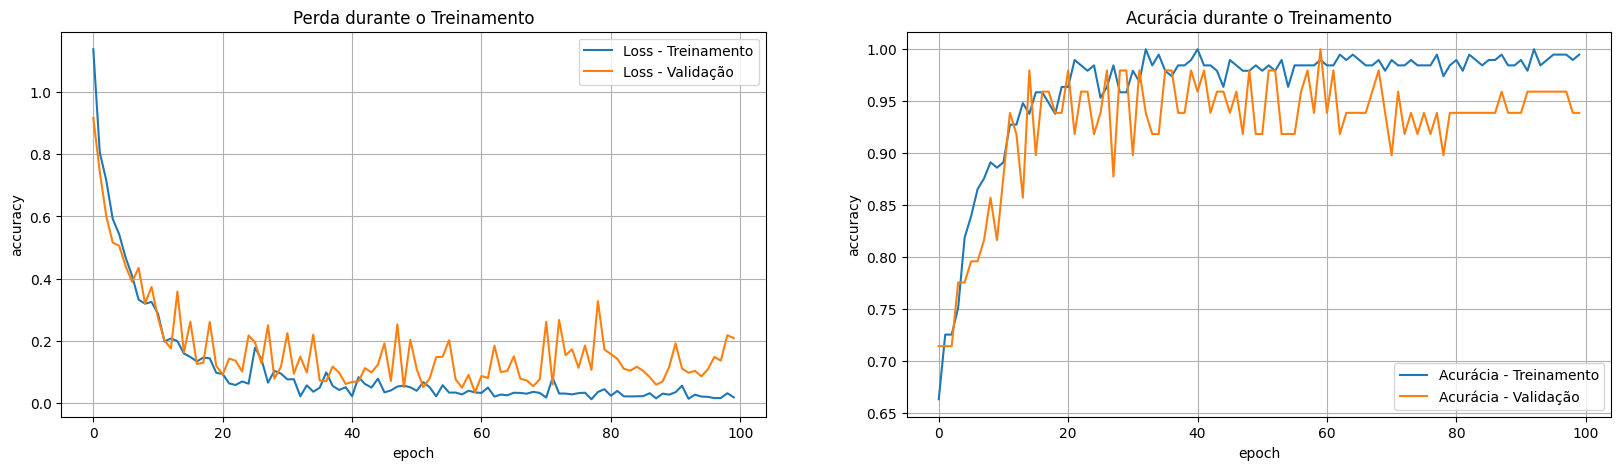

In [373]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss - Treinamento')
plt.plot(history.history['val_loss'], label='Loss - Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('epoch'), plt.ylabel('accuracy'), plt.legend(), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia - Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia - Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('epoch'), plt.ylabel('accuracy'), plt.legend(), plt.grid()
plt.show()

# TESTANDO MODELO

In [381]:
from tensorflow.keras.models import load_model
model = load_model('Model/model.keras')
model

<Sequential name=sequential_15, built=True>

In [382]:
def cleanSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    sentenceWords = nltk.word_tokenize(sentence)
    return [lemmatizer.lemmatize(word) for word in sentenceWords if word not in ignoreWords]

def getBagOfWords(sentenceWords):
    with open('Model/words.pkl', 'rb') as file:
        words = pickle.load(file)
    
    bag = [0 for i in words]

    for w in sentenceWords:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1

    return np.array(bag)


def predictClass(sentence):
    global model
    sentence = cleanText(sentence)

    with open('Model/classes.pkl', 'rb') as file:
        classes = pickle.load(file)

    sentenceWords = cleanSentence(sentence)
    bagOfWords    = getBagOfWords(sentenceWords)

    xData = np.array([bagOfWords])
    predictions = model.predict(xData)[0]

    predictions = [[i, prob] for i, prob in enumerate(predictions) if prob > 0.1]
    return {classes[i]: prob for (i, prob) in predictions}



result = predictClass('Oi')
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


{'cumprimento': 1.0}

In [383]:
def getResponse(sentence):
    result = predictClass(sentence)
    
    if len(result) == 0:
        return None
    
    tag = max(result, key=result.get)

    for intent in intents:
        if tag == intent['tag']:
            response = intent['responses']
            return random.choice(response)
    return None


getResponse('Olá! Tudo bem?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


'Olá! Espero que esteja tudo bem com você.'

# NOVOS DADOS

In [384]:
classes = set([intent['tag'] for intent in intents])
classes

{'como', 'cumprimento', 'despedida', 'piada', 'sighir'}

In [385]:
getResponse('O que é a Sighir?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'A Sighir trabalha com inovação tecnológica.'

In [386]:
getResponse('valeu então, fica com deus')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


'Olá! Espero que esteja tudo bem com você.'

In [403]:
getResponse('como você esta?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


'Estou bem, obrigado por perguntar!'